## Importing libs

In [1]:
#From https://mne.tools/stable/auto_examples/simulation/simulate_raw_data.html#sphx-glr-auto-examples-simulation-simulate-raw-data-py
import matplotlib.pyplot as plt
import numpy as np
import mne
from mne import Epochs, compute_covariance, find_events, make_ad_hoc_cov
from mne.datasets import sample
from mne.simulation import (
    add_ecg,
    add_eog,
    add_noise,
    simulate_raw,
    simulate_sparse_stc,
    
)
from mne.minimum_norm import apply_inverse, make_inverse_operator
from mne.beamformer import apply_lcmv, make_lcmv
from mne.datasets import fetch_fsaverage, sample

### Loading data for experimental setup from mne sample


In [2]:
data_path = sample.data_path()
meg_path = data_path / "MEG" / "sample"
raw_fname = meg_path / "sample_audvis_raw.fif"
fwd_fname = meg_path / "sample_audvis-meg-eeg-oct-6-fwd.fif"
subjects_dir = data_path / "subjects"
raw = mne.io.read_raw_fif(raw_fname)
noise_cov=mne.read_cov(meg_path / "sample_audvis-cov.fif")
subject = "sample"
annot = "aparc.a2009s"
sfreq =raw.info["sfreq"]
tstep = 1 /sfreq
fwd = mne.read_forward_solution(fwd_fname)
src = fwd["src"]


Opening raw data file /home/hp/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle


    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
    366 x 366 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading forward solution from /home/hp/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Forward solutions 

In [3]:
src1 = src.copy()

In [4]:
mne.add_source_space_distances(src=src1)

Calculating source space distances (limit=inf mm)...


    Computing patch statistics...
    Patch information added...
    Computing patch statistics...
    Patch information added...


<SourceSpaces: [<surface (lh), n_vertices=155407, n_used=3732>, <surface (rh), n_vertices=156866, n_used=3766>] head coords, subject 'sample', ~32.1 MB>

In [5]:
mne.write_source_spaces("distance_computed_sample_audvis-meg-eeg-oct-6-src.fif",src1)

    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


In [6]:
# I think provided distances are only for neighbouring vertces and others are computed as 0
gdist_vertices= src1[0]["dist"][src1[0]["vertno"][:,np.newaxis],src1[0]["vertno"]].toarray()


In [36]:
#check if they are similar just for sanity check
gdist_vertices[0,7], src[0]["dist"][src[0]["vertno"][:,np.newaxis],src[0]["vertno"]][0,7]

(0.0050495253, 0.0050495192)

## parameter setup

In [8]:
epoch_duration = 1  # duration of each epoch
times = raw.times[: int(raw.info["sfreq"] * epoch_duration)]
n_dipoles = 2 # number of dipoles to create
extent = 5.0 #exten=0 means a single dipole,  try to create a sequentially larger sources later
rng = np.random.RandomState(0)  # random state (make reproducible)


In [64]:
import numpy as np

# Precompute the indices for vertices_in_aud_cortex

# Iterate over precomputed indices
for i_vertex in vertices_in_aud_cortex:
    i = vertex_indices[i_vertex]
    for j_vertex in vertices_in_aud_cortex:
        j = vertex_indices[j_vertex]
        print(gdist_vertices[i, j],i,j)



0.0 1671 1671
0.004991136 1671 1702
0.004942303 1671 1741
0.0060309786 1671 1780
0.008410105 1671 1830
0.011304864 1671 1872
0.010315298 1671 1953
0.011535422 1671 1955
0.016313102 1671 2036
0.016111333 1671 2104
0.022665123 1671 2174
0.021309564 1671 2215
0.020473707 1671 2216
0.026873028 1671 2351
0.02509538 1671 2381
0.028178183 1671 2478
0.033514712 1671 2588
0.036503293 1671 2667
0.03679014 1671 2691
0.004991136 1702 1671
0.0 1702 1702
0.008263146 1702 1741
0.0049998327 1702 1780
0.0046510003 1702 1830
0.013016492 1702 1872
0.010584355 1702 1953
0.0092477 1702 1955
0.01658216 1702 2036
0.015743157 1702 2104
0.023320712 1702 2174
0.021436483 1702 2215
0.019193944 1702 2216
0.027142085 1702 2351
0.02464383 1702 2381
0.027294809 1702 2478
0.03306316 1702 2588
0.03561992 1702 2667
0.03449759 1702 2691
0.004942303 1741 1671
0.008263146 1741 1702
0.0 1741 1741
0.005104151 1741 1780
0.008833859 1741 1830
0.006362561 1741 1872
0.0064091505 1741 1953
0.009470503 1741 1955
0.011511997 1741 

In [54]:
gdist_vertices[np.meshgrid([np.where(src[0]["vertno"]==i)[0][0] for i in saving_vertices])]*1000

array([[[[166.45343 , 159.72614 , 165.13889 , ...,  74.263565,
          126.94895 , 102.43272 ],
         [169.8081  , 163.0808  , 168.49356 , ...,  76.17364 ,
          123.863815, 104.42214 ]],

        [[166.45343 , 159.72614 , 165.13889 , ...,  74.263565,
          126.94895 , 102.43272 ],
         [169.8081  , 163.0808  , 168.49356 , ...,  76.17364 ,
          123.863815, 104.42214 ]]],


       [[[166.45343 , 159.72614 , 165.13889 , ...,  74.263565,
          126.94895 , 102.43272 ],
         [166.45343 , 159.72614 , 165.13889 , ...,  74.263565,
          126.94895 , 102.43272 ]],

        [[169.8081  , 163.0808  , 168.49356 , ...,  76.17364 ,
          123.863815, 104.42214 ],
         [169.8081  , 163.0808  , 168.49356 , ...,  76.17364 ,
          123.863815, 104.42214 ]]]], dtype=float32)

### Selecting the labels for vertices of dipoles


In [9]:
label_primary_aud_cortex = mne.read_labels_from_annot(
            subject, annot, subjects_dir=subjects_dir, regexp="G_temp_sup-G_T_transv-lh", verbose=False )# can also use G_occipital_middle-lh , G_temp_sup-G_T_transv-lh
label_primary_aud_cortex =   label_primary_aud_cortex*n_dipoles
vertices_in_aud_cortex =np.intersect1d(src[0]["vertno"], label_primary_aud_cortex[0].vertices) #
vertex_indices = {vertex: np.where(src[0]["vertno"] == vertex)[0][0] for vertex in vertices_in_aud_cortex}

indices_in_label = np.where(np.isin(label_primary_aud_cortex[0].vertices, vertices_in_aud_cortex))[0]
print(f"Number of dipoles is {'lower/equal' if n_dipoles <= vertices_in_aud_cortex.shape[0] else 'higher'} than the total vertices in the label border")

label_dipole = []
saving_vertices=[]
for one_dipole in np.random.choice(indices_in_label,n_dipoles, replace=False): # Creating a label object for 
  # One dipole source                                          # each vertices, that can be passed down to simulator
    saving_vertices .append( label_primary_aud_cortex[0].vertices[one_dipole])
    label_dipole.append(mne.label.select_sources(
    subject,
    label_primary_aud_cortex[0],
    location=one_dipole,
    extent=extent,
    subjects_dir=subjects_dir,
    random_state=rng,           
    ))

indices_in_vertno = [np.where(src[0]["vertno"]==i)[0][0] for i in saving_vertices]



Number of dipoles is lower/equal than the total vertices in the label border


## Defining wavelet function


In [10]:
## function to make simple N100 like wavelet with damped sine
def simple_evoked(times):
    base_amplitude = 50e-9
    min_amplitude = 4e-8
    frequency = 7
    peak_time = 0.1
    std_dev = 0.003 * abs(np.random.randn(1))
    amplitude = max(min_amplitude, base_amplitude * abs(np.random.randn(1)))

    phase_shift = -np.pi / 2 - 2 * np.pi * frequency * peak_time
    sine_wave = np.sin(2 * np.pi * frequency * times + phase_shift)
    gaussian_envelope = np.exp(-((times - peak_time ) ** 2) / std_dev)
    signal = amplitude * sine_wave * gaussian_envelope
    
    return signal



## Defining events and signal associated with each events , here one source will only have one kind of wave repeated at each trial

In [11]:
signal_matrix =  np.zeros((n_dipoles,times.shape[0]))
trials_no = 50
n_events = trials_no * n_dipoles
events = np.zeros((n_events, 3), int)

events[:, 0] = 100+400 * np.arange(n_events)  
for i in range(n_dipoles):
    signal_matrix[int(i),:]=simple_evoked(times)
    events[trials_no *(i):trials_no *(i+1), 2] = i+1
  
np.random.shuffle(events[:, 2]) # nonsequential event timings

## Adding data to sourcesimulator object

In [12]:
source_simulator_dipole = mne.simulation.SourceSimulator(src, tstep=tstep)
for i in  range(n_dipoles):
    source_simulator_dipole.add_data(label_dipole[i], signal_matrix[i,:], events[events[:,2]==i+1])

In [13]:
raw_sim = mne.simulation.simulate_raw(raw.info, source_simulator_dipole, forward=fwd)
raw_dipole = raw_sim.pick(picks=["meg", "stim"])
# cov = mne.make_ad_hoc_cov(raw_sim.info)
cov = noise_cov # I am loading noise cov data from sample provided by mne
mne.simulation.add_noise(
    raw_dipole, cov, random_state=rng)  #iir_filter=[0.2, -0.2, 0.04]

Setting up raw simulation: 1 position, "cos2" interpolation


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,MEG
Participant,Unknown
Digitized points,146 points
Good channels,"203 Gradiometers, 102 Magnetometers, 9 Stimulus"
Bad channels,MEG 2443
EOG channels,Not available
ECG channels,Not available
Sampling frequency,600.61 Hz
Highpass,0.10 Hz
Lowpass,172.18 Hz


## Saving evoked and epochs in a dict

In [14]:
epochs_dict = dict()
evoked_dict = dict()

for i in range(n_dipoles):
    epochs_dict[f'epoch_{i+1}']= mne.Epochs(raw_dipole, events, i+1, tmin=-0.2, tmax=0.6, baseline=(None,0.0))
    evoked_dict[f'epoch_{i+1}'] = epochs_dict[f'epoch_{i+1}'].average().pick("mag").filter(l_freq=None, h_freq=40.0, picks=None, filter_length='auto',verbose=False)


Not setting metadata
50 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)


Created an SSP operator (subspace dimension = 3)
3 projection items activated
Not setting metadata
50 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated


# Inverse modelling

In [15]:
snr = 3.0
inv_methods_list = ['sLORETA',"MNE","eLORETA","dSPM"]
lambda2 = 1.0 / snr**2
inv_meth_dict = dict()
for inv_method in inv_methods_list: #Probably use another way to store data later if there are 100s of sources, rather than dict of dict
    stc_est_dipole_dict=dict()      # Also change i and j in all loops 
    peak_dict = dict()

    for i,j in evoked_dict.items():
        inverse_operator = make_inverse_operator(j.info, fwd, cov, loose="auto", depth=0.8,fixed=True)
        stc_est_dipole_dict[i] = apply_inverse(j, inverse_operator, lambda2, inv_method, pick_ori=None,method_params={"max_iter":100})
        peak_dict[i] = stc_est_dipole_dict[i].get_peak(hemi="lh")[0]

    inv_meth_dict[f"{inv_method}"] = {"peak_coord":peak_dict,"stc_est_dict":stc_est_dipole_dict}

info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 102 channels.
    102 out of 366 channels remain after picking
Selected 102 channels
Creating the depth weighting matrix...
    102 magnetometer or axial gradiometer channels
    limit = 7439/7498 = 10.080653
    scale = 2.36559e-11 exp = 0.8
    Picked elements from a free-orientation depth-weighting prior into the fixed-orientation one
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank=None
    Using tolerance 2.5e-14 (2.2e-16 eps * 102 dim * 1.1  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 3 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source cov

## Visualisation of peak coordinates wrt simulation vertices

In [26]:
for inv_method in inv_methods_list:
    peak_dict = inv_meth_dict[inv_method]["peak_coord"]

    brain_kwargs = dict(alpha=0.2, background="white", cortex="low_contrast",title=f"{inv_method}Vertices in Aud Cortex Present in SOurce Space")

    correct=(np.array(list(peak_dict.values())) ==np.array(saving_vertices))

    brain = mne.viz.Brain("sample", subjects_dir=subjects_dir, **brain_kwargs)
    if extent==0:
        brain.add_foci(np.array(saving_vertices),hemi="lh",color="blue",scale_factor=0.2,alpha=0.3)
    else:
        brain.add_label(label_dipole[0],hemi="lh", subdir="/home/hp/mne_data/MNE-sample-data/subjects/fsaverage/label/lh.aparc.a2009s",color="blue",borders=False)

    brain.add_foci(
    np.array(list(peak_dict.values())),
    coords_as_verts=True,
    hemi="lh",
    color="red",
    scale_factor=0.4,
    alpha=0.1,
    )
    brain.add_label(
        label_primary_aud_cortex[0], hemi="lh", color="green", subdir="/home/hp/mne_data/MNE-sample-data/subjects/fsaverage/label/lh.aparc.a2009s",borders=True)
    #brain.save_image(f"images_to_mne_forum/{inv_method}_sct_peak_original_coord_peak.png")
    #brain.close()


In [48]:
brain.save_image(f"images_to_mne_forum/zoomed_{inv_method}_sct_peak_original_coord_peak.png")


--------------------------------------------------------------------------------------------------------------------------------------------

# SUPLLEMENTARY


## Average signal

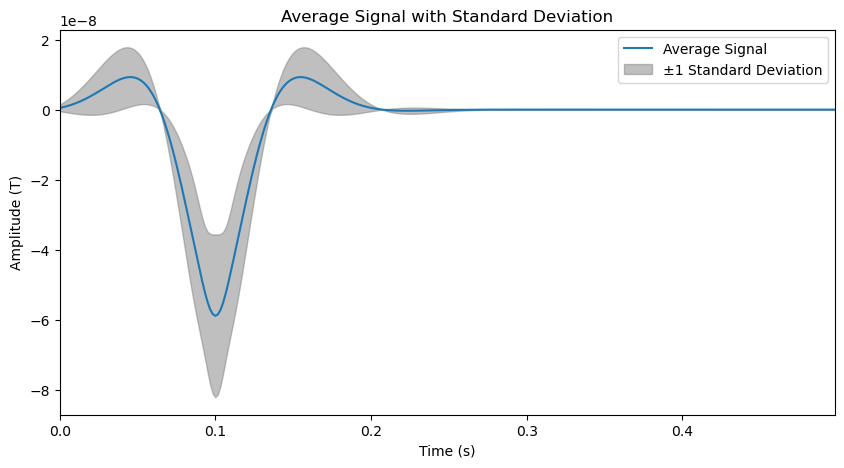

In [10]:
# epoch length is too long , change plot_samp when wavelet is wider to visualise betetr
plot_samp = 300
times_plot = times[:plot_samp]

average_signal = np.mean(signal_matrix[:, :plot_samp], axis=0)
std_signal = np.std(signal_matrix[:, :plot_samp], axis=0)

plt.figure(figsize=(10, 5))
plt.plot(times_plot, average_signal, label='Average Signal')
plt.fill_between(times_plot, average_signal - std_signal, average_signal + std_signal, color='gray', alpha=0.5, label='±1 Standard Deviation')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (T)')
plt.title('Average Signal with Standard Deviation')
plt.legend()
plt.xlim([times_plot[0], times_plot[-1]])  # Adjust x-axis limits
plt.savefig('average_signal_with_std.png', dpi=400)
plt.show()

## Location of label and vertices

In [11]:
# Visualisation of selected dipoles and label
brain_kwargs = dict(alpha=0.2, background="white", cortex="low_contrast",title="Vertices in Aud Cortex Present in SOurce Space")
brain = mne.viz.Brain("sample", subjects_dir=subjects_dir, **brain_kwargs)
#brain.add_foci(vertices_in_aud_cortex,hemi="lh",coords_as_verts=True,color="red",scale_factor=0.2)
brain.add_label(
        label_primary_aud_cortex[0], hemi="lh", color="green", subdir="/home/hp/mne_data/MNE-sample-data/subjects/fsaverage/label/lh.aparc.a2009s",borders=False)

brain.add_foci(saving_vertices,hemi="lh",coords_as_verts=True,color="blue",scale_factor=0.2,alpha=1)


## Events plot

In [ ]:
events = mne.find_events(raw_dipole, initial_event=True,min_duration=0)
fig = mne.viz.plot_events(
    events, sfreq=raw.info["sfreq"], first_samp=raw_sim.first_samp
)

## Example evoked plots

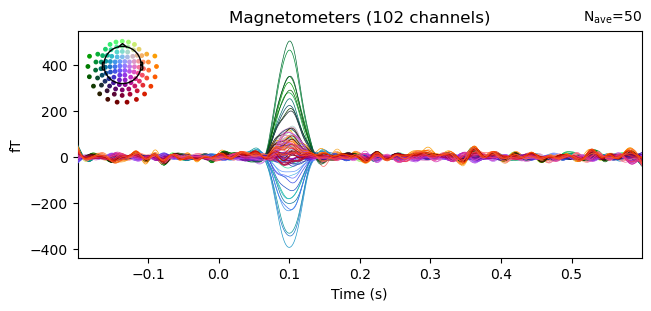

In [51]:
fig= evoked_dict["epoch_1"].plot()

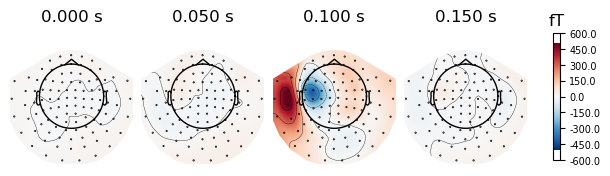

In [52]:
fig=evoked_dict["epoch_1"].plot_topomap(np.array([0.0,0.05,0.1,0.15]))

Computing rank from covariance with rank=None
    Using tolerance 2.5e-14 (2.2e-16 eps * 102 dim * 1.1  max singular value)
    Estimated rank (mag): 102
    MAG: rank 102 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 2.6e-12 (2.2e-16 eps * 204 dim * 56  max singular value)
    Estimated rank (grad): 204
    GRAD: rank 204 computed from 204 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 4.8e-14 (2.2e-16 eps * 60 dim * 3.6  max singular value)
    Estimated rank (eeg): 60
    EEG: rank 60 computed from 60 data channels with 0 projectors


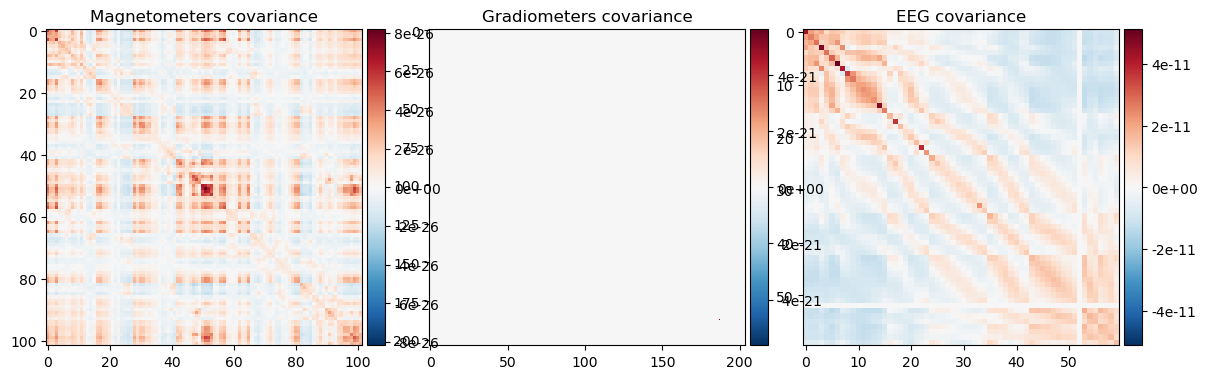

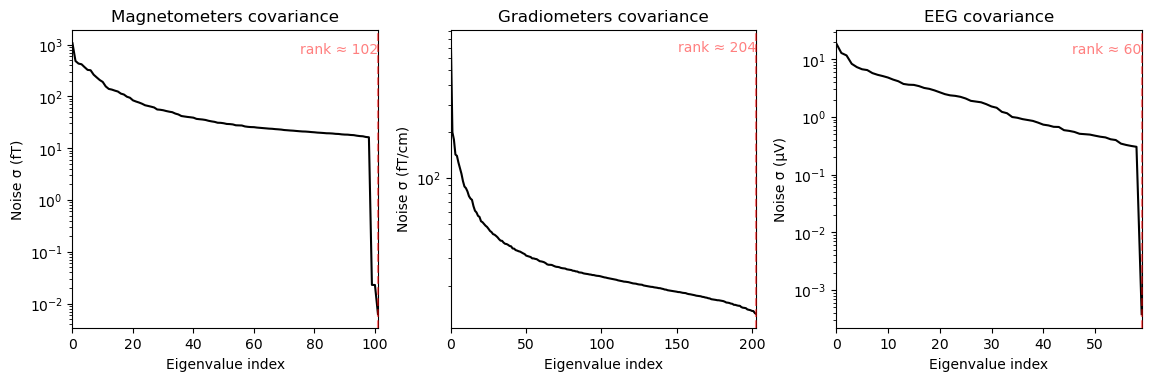

(<Figure size 1140x370 with 6 Axes>, <Figure size 1140x370 with 3 Axes>)

In [25]:
cov.plot(raw.info)